In [1]:
!pip install baostock
import baostock as bs
import pandas as pd
from datetime import datetime, timedelta
import numpy as np

In [2]:
lg = bs.login()
print(f'login respond code: {lg.error_code}')
print(f'login respond msg: {lg.error_msg}')
params = ','.join(['date', 'open', 'high', 'low', 'close', 'preclose','volume','amount','turn', 'tradestatus', 'pctChg'])

login success!
login respond code: 0
login respond msg: success


In [0]:
def query_history_k_data_plus_with_df(**kwargs) -> pd.DataFrame:
    rs = bs.query_history_k_data_plus(**kwargs)
    data_list = []
    if rs.error_code!='0':
        raise Exception(f'error in fetch message: {rs.error_msg}')
    while rs.error_code == '0' and rs.next():
        data_list.append(rs.get_row_data())
    return pd.DataFrame(data_list, columns=rs.fields)

In [0]:
def fill_suspension(raw_df: pd.DataFrame, start_date: str, end_date: str) -> pd.DataFrame:
    start = datetime.strptime(start_date,'%Y-%m-%d')
    end = datetime.strptime(end_date, '%Y-%m-%d')
    date_counter = dict()
    columns = raw_df.columns.tolist()
    date_index = columns.index('date')
    close_index = columns.index('close')
    for r in raw_df.values:
        date_counter[r[date_index]] = list(r)
    first_record = raw_df.iloc[0]
    first_date = datetime.strptime(first_record['date'],'%Y-%m-%d')
    current = start
    last_close = first_record['close']
    while current < first_date:
        current_str = current.strftime('%Y-%m-%d')
        date_counter[current_str] = [current_str,last_close, last_close, last_close,last_close,last_close,0,0.0,0.0,0,0.0]
        current = current + timedelta(days=1)
    while current <= end:
        current_str = current.strftime('%Y-%m-%d')
        if date_counter.get(current_str) is None:
            last_day_str = (current + timedelta(days=-1)).strftime('%Y-%m-%d')
            last = date_counter.get(last_day_str) 
            last_close = last[close_index]
            date_counter[current_str] = [current_str,last_close, last_close, last_close,last_close,last_close,0,0.0,0.0,0,0.0] 
        current = current + timedelta(days=1)
    new_data = sorted(date_counter.values(),key=lambda x: x[date_index])
    return pd.DataFrame(new_data,columns=columns)

In [0]:
import os
import csv

def load_history_k_data_plus_with_df(**kwargs) -> pd.DataFrame:
    code = kwargs.get('code')
    frequency = kwargs.get('frequency')
    adjust = kwargs.get('adjustflag')
    path = os.path.join('.','resources',f'{code}-{frequency}-{adjust}.csv')
    if not os.path.exists(path):
        rs = query_history_k_data_plus_with_df(**kwargs)
        # rs = fill_suspension(rs, kwargs.get('start_date'), kwargs.get('end_date'))
        rs.to_csv(path, index=False, encoding='utf-8', quoting=csv.QUOTE_NONNUMERIC)
    rs = pd.read_csv(path, quoting=csv.QUOTE_NONNUMERIC)
    return rs

In [0]:
start_date = '2006-01-01'
end_date = '2019-10-20'

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
os.chdir('/content/drive/My Drive/workspace/comp3035/')

In [9]:
rs_no  = load_history_k_data_plus_with_df(code="sh.000001",start_date=start_date, end_date=end_date,fields=params,frequency='d', adjustflag = '3')
rs_all = rs_no
rs_all.head()

,date,open,high,low,close,preclose,volume,amount,turn,tradestatus,pctChg
0,2006-01-04,1163.878,1181.004,1161.906,1180.963,1161.057,2.325854e+09,1.197043e+10,0.015049,1.0,1.714473
1,2006-01-05,1183.305,1197.837,1180.451,1197.269,1180.963,2.948448e+09,1.476720e+10,0.019075,1.0,1.380740
2,2006-01-06,1198.811,1215.536,1191.614,1209.422,1197.269,3.434286e+09,1.713047e+10,0.022207,1.0,1.015056
3,2006-01-09,1210.320,1217.314,1205.248,1215.668,1209.422,2.870666e+09,1.420640e+10,0.018558,1.0,0.516443
4,2006-01-10,1215.848,1220.756,1203.651,1220.618,1215.668,2.679455e+09,1.349637e+10,0.017307,1.0,0.407190


In [10]:
dataset = rs_all.set_index('date')
dataset['range'] = dataset['high'] - dataset['low']
dataset['chg'] = dataset['close'] - dataset['open']
dataset['predict'] = dataset['close'].shift(-1)
dataset['trend'] = (dataset['predict']-dataset['close']).apply(lambda x: 1 if x>=0 else 0)
dataset = dataset.dropna(axis=0)
dataset.head()

,open,high,low,close,preclose,volume,amount,turn,tradestatus,pctChg,range,chg,predict,trend
date,,,,,,,,,,,,,,
2006-01-04,1163.878,1181.004,1161.906,1180.963,1161.057,2.325854e+09,1.197043e+10,0.015049,1.0,1.714473,19.098,17.085,1197.269,1
2006-01-05,1183.305,1197.837,1180.451,1197.269,1180.963,2.948448e+09,1.476720e+10,0.019075,1.0,1.380740,17.386,13.964,1209.422,1
2006-01-06,1198.811,1215.536,1191.614,1209.422,1197.269,3.434286e+09,1.713047e+10,0.022207,1.0,1.015056,23.922,10.611,1215.668,1
2006-01-09,1210.320,1217.314,1205.248,1215.668,1209.422,2.870666e+09,1.420640e+10,0.018558,1.0,0.516443,12.066,5.348,1220.618,1
2006-01-10,1215.848,1220.756,1203.651,1220.618,1215.668,2.679455e+09,1.349637e+10,0.017307,1.0,0.407190,17.105,4.770,1211.053,0


In [11]:
print(len(dataset))

3351


In [36]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
float_data = dataset.iloc[:,:-1].values
float_data = scaler.fit_transform(float_data)
print(float_data.shape)
float_data

(3351, 13)


array([[0.        , 0.        , 0.        , ..., 0.02991361, 0.56726887,
        0.        ],
       [0.00396992, 0.00340539, 0.00380113, ..., 0.02589224, 0.56207025,
        0.00248285],
       [0.00713858, 0.00698598, 0.00608919, ..., 0.04124484, 0.5564852 ,
        0.0037589 ],
       ...,
       [0.37637012, 0.36913721, 0.37394326, ..., 0.03053137, 0.51445985,
        0.36394692],
       [0.37370253, 0.37010018, 0.37181569, ..., 0.06609415, 0.51566081,
        0.36366539],
       [0.37112403, 0.36530455, 0.37051312, ..., 0.02534024, 0.53438316,
        0.3556583 ]])

In [0]:
delay_close = float_data[:,-1]
float_data = float_data[:,:-1]
delay_trend = dataset.values[:,-1]

In [14]:
delay_close

array([1197.269, 1209.422, 1215.668, ..., 2978.712, 2977.334, 2938.141])

In [15]:
delay_trend

array([1., 1., 1., ..., 0., 0., 0.])

In [0]:
import random
from typing import Union
def generator(x, y, lookback: int, min_index: Union[int,None], max_index: Union[int,None], 
              shuffle: True, shuffle_seed:int=0):
  indices = list(range(lookback, len(x)))
  if shuffle:
    random.Random(shuffle_seed).shuffle(indices)
  if max_index is not None and min_index is not None:
    indices = indices[min_index:max_index+1]
  elif max_index is None and min_index is None:
    pass
  elif max_index is None:
    indices = indices[min_index:]
  elif min_index is None:
    indices = indices[:max_index]
  res_x = []
  res_y = []
  for i in indices:
    res_x.append(x[i-lookback:i+1])
    res_y.append(y[i])
  res_x = np.asarray(res_x, dtype=np.float32)
  res_y = np.asarray(res_y)
  return (res_x,res_y)

In [17]:
shuffle=True
shuffle_seed = 0
lookback = 31
target = delay_trend
train_data = generator(float_data, target, lookback=lookback, 
                       min_index=None, max_index=2850, 
                       shuffle=shuffle, shuffle_seed=shuffle_seed)
valid_data = generator(float_data, target, lookback=lookback, 
                       min_index=2851, max_index=None, 
                       shuffle=shuffle, shuffle_seed=shuffle_seed)
print(train_data[0].shape)
print(train_data[1].shape)
train_data[1]

(2850, 32, 12)
(2850,)


array([1., 1., 1., ..., 0., 0., 0.])

In [0]:
from tensorflow.keras import models, layers, optimizers, losses, activations, metrics

In [0]:
model = models.Sequential()
model.add(layers.Conv1D(64, 5, activation=activations.relu,
                        input_shape=(None, train_data[0].shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(64, 5, activation=activations.relu))
model.add(layers.GRU(64, 
                      dropout=0.1, 
                      recurrent_dropout=0.5, 
                      return_sequences=False,
                      ))
model.add(layers.Dense(1, activation=activations.sigmoid))
model.compile(optimizer=optimizers.RMSprop(lr=1e-5), 
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy]
              )

In [30]:
history = model.fit(train_data[0], train_data[1], 
                    batch_size=64, 
                    epochs = 10,
                    validation_data=(valid_data[0],valid_data[1]))

Train on 2850 samples, validate on 469 samples
Epoch 1/10
2850/2850 [==============================] - 2s 724us/sample - loss: 0.6959 - binary_accuracy: 0.4611 - val_loss: 0.6959 - val_binary_accuracy: 0.4542
Epoch 2/10
2850/2850 [==============================] - 1s 257us/sample - loss: 0.6945 - binary_accuracy: 0.4709 - val_loss: 0.6947 - val_binary_accuracy: 0.4968
Epoch 3/10
2850/2850 [==============================] - 1s 283us/sample - loss: 0.6935 - binary_accuracy: 0.4930 - val_loss: 0.6937 - val_binary_accuracy: 0.4904
Epoch 4/10
2850/2850 [==============================] - 1s 275us/sample - loss: 0.6922 - binary_accuracy: 0.5260 - val_loss: 0.6929 - val_binary_accuracy: 0.5075
Epoch 5/10
2850/2850 [==============================] - 1s 247us/sample - loss: 0.6918 - binary_accuracy: 0.5368 - val_loss: 0.6923 - val_binary_accuracy: 0.5203
Epoch 6/10
2850/2850 [==============================] - 1s 249us/sample - loss: 0.6912 - binary_accuracy: 0.5389 - val_loss: 0.6919 - val_binar

In [40]:
shuffle=True
shuffle_seed = 0
lookback = 31
target = delay_close
train_data = generator(float_data, target, lookback=lookback, 
                       min_index=None, max_index=2850, 
                       shuffle=shuffle, shuffle_seed=shuffle_seed)
valid_data = generator(float_data, target, lookback=lookback, 
                       min_index=2851, max_index=None, 
                       shuffle=shuffle, shuffle_seed=shuffle_seed)
print(train_data[0].shape)
print(train_data[1].shape)

(2850, 32, 12)
(2850,)


In [0]:
model = models.Sequential()
model.add(layers.Conv1D(64, 5, activation=activations.relu,
                        input_shape=(None, train_data[0].shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(64, 5, activation=activations.relu))
model.add(layers.GRU(64, 
                      dropout=0.1, 
                      recurrent_dropout=0.5, 
                      return_sequences=False,
                      ))
model.add(layers.Dense(1))
model.compile(optimizer=optimizers.RMSprop(lr=1e-5), 
              loss=losses.mse,
              metrics=[metrics.mse]
              )

In [45]:
history = model.fit(train_data[0], train_data[1], 
                    batch_size=16, 
                    epochs = 20,
                    validation_data=(valid_data[0],valid_data[1]))

Train on 2850 samples, validate on 468 samples
Epoch 1/20
2850/2850 [==============================] - 4s 2ms/sample - loss: 0.0488 - mean_squared_error: 0.0488 - val_loss: 0.0078 - val_mean_squared_error: 0.0078
Epoch 2/20
2850/2850 [==============================] - 2s 640us/sample - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 3/20
2850/2850 [==============================] - 2s 640us/sample - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 4/20
2850/2850 [==============================] - 2s 646us/sample - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 5/20
2850/2850 [==============================] - 2s 643us/sample - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 6/20
2850/2850 [==============================] - 2s 630us/sample - loss: 0.0034 - mean_squared_error: 0.0034

In [0]:
test_data = generator(float_data, target, lookback=lookback, 
                       min_index=-365, max_index=None, 
                       shuffle=False, shuffle_seed=None)
pred = model.predict(test_data[0])

In [0]:
inversed = scaler.inverse_transform(np.concatenate(
    (float_data[-365:], pred.reshape((pred.shape[0],1))), axis=1))
true = inversed[:,3]
pred = inversed[:,-1]

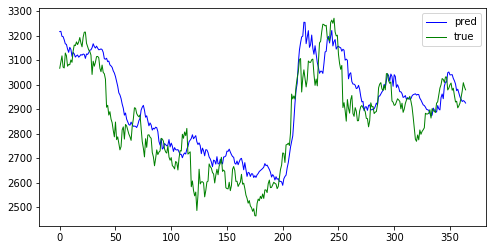

In [65]:
from matplotlib import pyplot as plt
points = len(true)
plt.figure(figsize=(8,4))
plt.plot(range(points),pred[-points:],'b-',label='pred',linewidth=1)
plt.plot(range(points),true[-points:],'g-',label='true', linewidth=1)
plt.legend()

In [66]:
from sklearn.metrics import mean_squared_error
print(f"mean squared error: {mean_squared_error(pred, true)}")

mean squared error: 10173.78106014124
